# Elastic 2D

This notebook demonstrates a 2D elastic wave simulation for scattering from a disc solid scatterer. We'll guide you through the setup process step by step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ultrawave import TimeAxis, ToneBurstSource, Receiver, plot_velocity
from ultrawave.lib.model_2d import Model
from ultrawave.lib.operator import Elastic2DOperator

## GPU acceleration

To use GPU to accelerate this simulation, you need to have NVIDIA HPC SDK installed, and run the following code.

If you don't want to use GPU, just skip this part. The code will automatically ran on CPU.

In [2]:
from devito import configuration
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

## Define the model

The model encapsulates the simulation grid and medium properties:

- **Grid Setup**: We start by defining a grid with specified spacing and shape.
- **Background Medium**: A homogeneous medium with a compressional wave speed of $1500 \text{ m/s}$, a shear wave speed of $0$, and a density of $1000 \text{ kg/m}^3$.


In [2]:
# Define grid spacing in [m]
spacing = (5.e-5, 5.e-5) # [m]

# The number of grid points in each dimension
shape = (int(40e-3/spacing[0]),
         int(10e-3/spacing[1]))

# Define the origin coordinate, which is the top left corner of the grid
origin = (0., 0.)

# Compressional wave speed
vp_background = 1500  # Background speed in [m/s].
vp = np.full(shape, vp_background, dtype=np.float32)

# Shear wave speed
vs_background = 0  # Background speed in [m/s].
vs = np.full(shape, vs_background, dtype=np.float32)

# Density
rho_background = 1000  # Background density in [kg/m^3].
rho = np.full(shape, rho_background, dtype=np.float32)

- **Disc Solid Scatterer**:
  - **Location**: $(x=20 \text{ mm}, z=8 \text{ mm})$.
  - **Radius**: $2 \text{ mm}$.
  - **Properties**: A compressional wave speed of $4030 \text{ m/s}$, a shear wave speed of $1645 \text{ m/s}$, and a density of $1960 \text{ kg/m}^3$.

In [3]:
# Define a disc scatterer.
a = 2.e-3 # Radius of the disc in [m].
r = int(a / spacing[0])  # Radius of the disc in grid points.
center_x, center_z = (int(20e-3/spacing[0]), int(6e-3/spacing[1])) # Center of the disc.
x, z = np.ogrid[-center_x:shape[0]-center_x,
                -center_z:shape[1]-center_z]

mask = (x**2 + z**2 <= r**2)
vp_scatter = 4030     # Compressional wave speed of scatterer in [m/s].
vs_scatter = 1645     # Shear wave speed of scatterer in [m/s].
rho_scatter = 1960     # Density of scatterer in [kg/m^3].
vp[mask] = vp_scatter
vs[mask] = vs_scatter
rho[mask] = rho_scatter

With the simulating grid and medium defined, we can create a 2D model with a time order of 2 and space order of 4. The size of boudary layers, also the perfectly matched layers, is 30 grid points.

In [4]:
time_order = 2
space_order = 4
nbl = 30  # Number of boundary layers. Size of PML

# Define simulation time.
t0 = 0.0  # Start time of the simulation.
tn = 15.e-6  # End time of the simulation [s].
dt = 6e-10  # Time step [s].
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num

# Create a model
model = Model(vp=vp, vs=vs, rho=rho,  b=1/rho, origin=origin, shape=shape, spacing=spacing, space_order=space_order, dt=dt, nbl=nbl)

## Define the source

A line source transmits a 3-cycle tone burst plane wave at a central frequency of $0.75 \text{ MHz}$. The planar source covers a range from $0$ to $40 \text{ mm}$ in x direction, with a fixed z-coordinate at $5 \text{ mm}$.

The source coordinates are defined out of grid and in the unit of meter. Here, for convenience, we make spacing between neighboring source points uniform and matching the grid spacing. The total number of source points is $\text{shape}[0]$.

In [5]:
# Define a line source.
f0 = 0.75e6 # Central frequency in [Hz]
src_npoints = shape[0]
src = ToneBurstSource(name='src', grid=model.grid, f0=f0, cycles=3, npoint=src_npoints, time_range=time_range) # source signal is a 3-cycle tone burst

# Define source coordinates
src.coordinates.data[:, 0] = np.arange(0., 40.e-3, spacing[0]) # x-direction
src.coordinates.data[:, 1] = 3.e-3 # z-direction
r_src = 6.e-3 - 3.e-3 # distance from source to scatterer

## Define the receiver
The definition of receiver is similar to source. We define a point receiver above the scatterer to receive the backscattered signal.

In [6]:
# Define a point receiver
rec = Receiver(name='rec', grid=model.grid, npoint=1, time_range=time_range)
rec.coordinates.data[:, 0] = 20.e-3
rec.coordinates.data[:, 1] = 2.e-3
r_rec = 6.e-3 - 2.e-3 # distance from receiver to scatterer

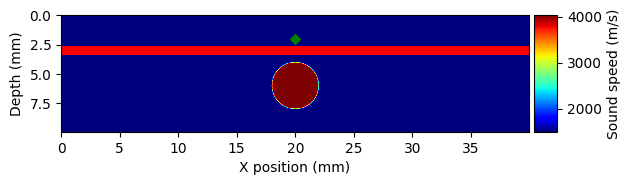

In [7]:
plot_velocity(model, source=src.coordinates.data, receiver=rec.coordinates.data)

## Operator
Operator acts as the computational engine of UltraWave. It takes the model, source, and receiver configurations as input and implement the wave equations.

In [11]:
# Define the operator
op = Elastic2DOperator(model, source=src, reciever=rec)

# Run the operator
op(time=time_range.num-1, dt=dt)
rec_signal = rec.data

Operator `Kernel` ran in 1.80 s


If running the operator takes too long on CPU, you can load this presaved data for convenience.


In [8]:
rec_signal = np.load('elastic_2d_rec_signal.npy')

Display the received signal.

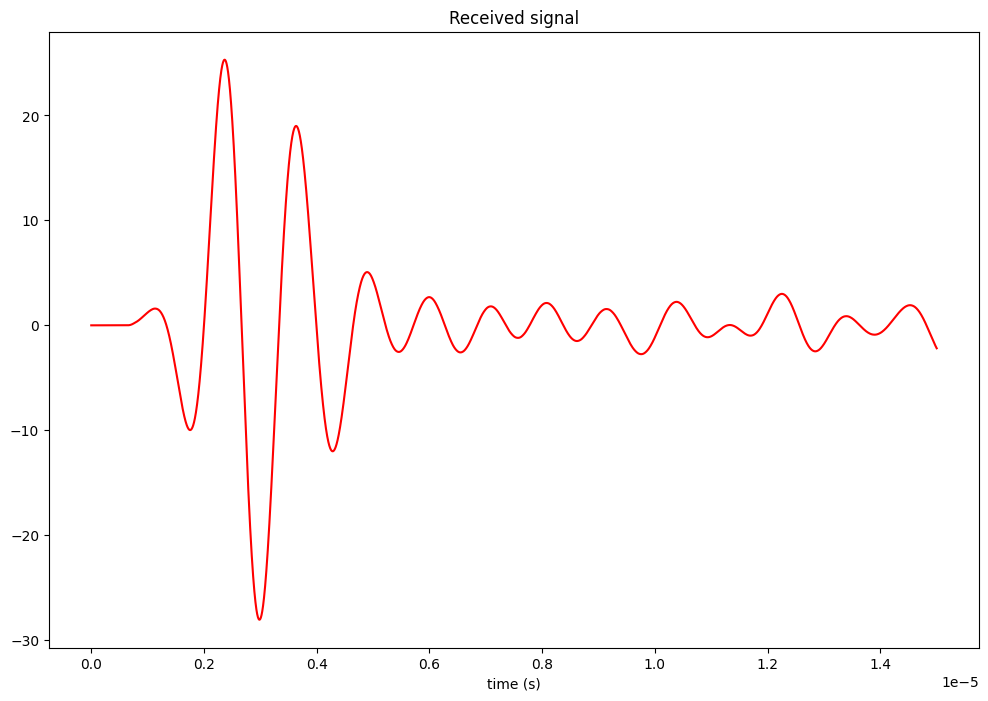

In [9]:
time = np.linspace(t0, tn, nt)
plt.figure(figsize=(12,8))
plt.plot(time, rec_signal, '-r')
plt.title('Received signal')
plt.xlabel('time (s)')
plt.show()

We substract the incident wave from the received signal to obtain the scattered signal.

To get the incident wave, we need to run a reference simulation without the scatterer. Here, we just load the presaved data.

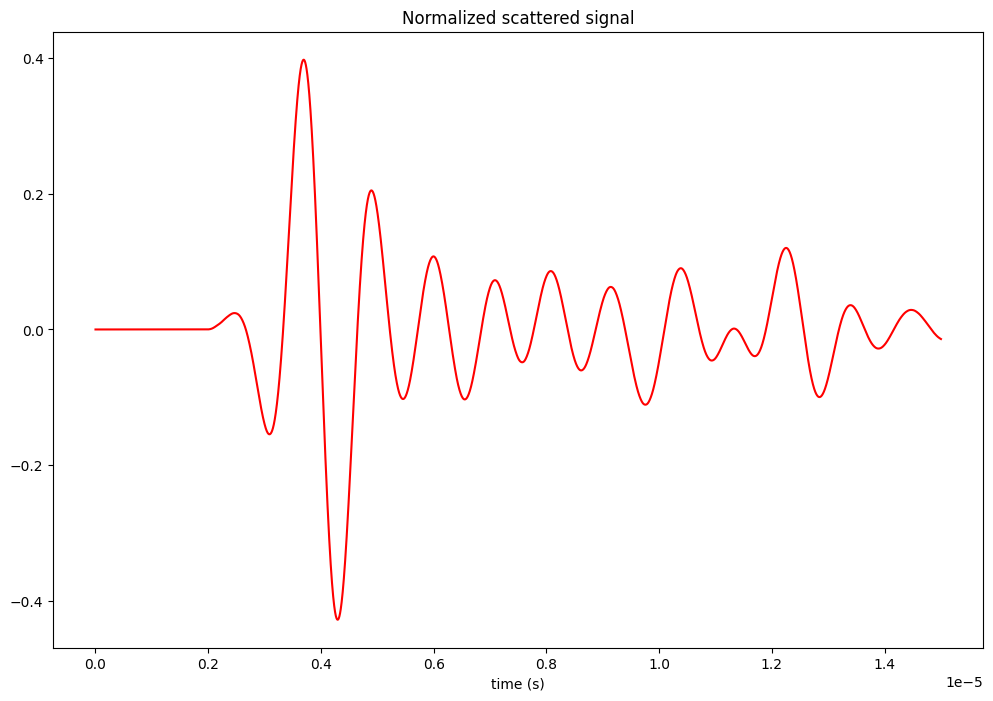

In [10]:
incident_signal = np.load('elastic_2d_incident_signal.npy') # load the presaved incident wave

normalized_scatter_signal = (rec_signal - incident_signal)/np.max(incident_signal) # normalized scattered signal

plt.figure(figsize=(12,8))
plt.plot(time, normalized_scatter_signal, '-r')
plt.title('Normalized scattered signal')
plt.xlabel('time (s)')
plt.show()

## Theoretical validation

We validate the simulation results against theoretical signals using MATLAB.

For convenience, here we use the MATLAB Engine API for Python to load the MATLAB code, which can be installed following the instructions at this [link](https://www.mathworks.com/help/matlab/matlab_external/python-setup-script-to-install-matlab-engine-api.html).

In [ ]:
import matlab.engine
eng = matlab.engine.start_matlab()
eng.cd(r'../theoretical_validation', nargout=0)

The function call and parameters are as follows:
[t, back, freq, back_f] = SolidCylinder(theta, r_rev, r_src, a, rho1, c1, c2, rho0, c0, source_signal, t_step)
Input parameters:

    theta         - Scattering angle in radians; theta=0 implies backscattering.
    r_rev         - Distance from the receiver to the center of the scatterer (m).
    r_src         - Distance from the planar source to the center of the scatterer (m).
    a             - Radius of the spherical scatterer (m).
    rho1          - Density of the scatterer (kg/m^3).
    c1            - Compressional wave speed of the scatterer (m/s).
    c2            - Shear wave speed of the scatterer (m/s).
    rho0          - Density of the background medium (kg/m^3).
    c0            - Compressional wave speed of the background medium (m/s).
    source_signal - The incident source signal, expected to be a 1xNt array.
    t_step        - Time step of the source signal (s).

Output parameters:

    t             - Time vector corresponding to the source signal.
    back          - Time-domain scattered signal, matching the length of the source signal.
    freq          - Frequency vector for the frequency-domain analysis.
    back_f        - Frequency-domain scattered signal, returned as a 1xNf complex array.

In [ ]:
source_signal = matlab.double(np.expand_dims(src.wavelet, axis=0))
source_signal = source_signal/np.max(source_signal)
theta = 0. # theta=0 implies backscattering
t, theoretical_signal = eng.SolidCylinder(theta, r_rec, r_src, a, rho_scatter, vp_scatter, vs_scatter, rho_background, vp_background, source_signal, dt)

In case you don't have MATLAB installed, we also have a presaved data for theoretical scattered signal.

In [11]:
import scipy
mat = scipy.io.loadmat('theoretical_scatter_signal_elastic_2d.mat')
t = mat['t']
t = t.squeeze()
theoretical_signal = mat['back']
theoretical_signal = theoretical_signal.squeeze()

Compare the simulated RF with theoretical RF.

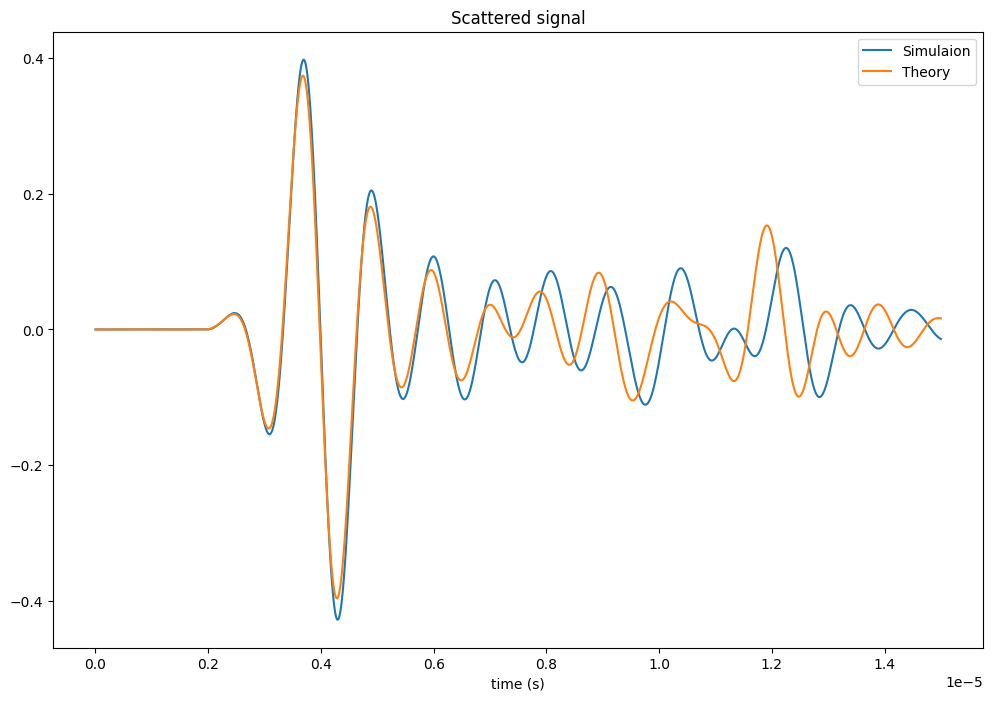

In [12]:
plt.figure(figsize=(12,8))
plt.plot(time, normalized_scatter_signal, label='Simulaion')
plt.plot(t, theoretical_signal, label='Theory')
plt.title('Scattered signal')
plt.xlabel('time (s)')
plt.legend()
plt.show()